Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
import zipfile
import os

zip_path = "/content/gdrive/MyDrive/CNN_assignment.zip"

extract_path = "content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

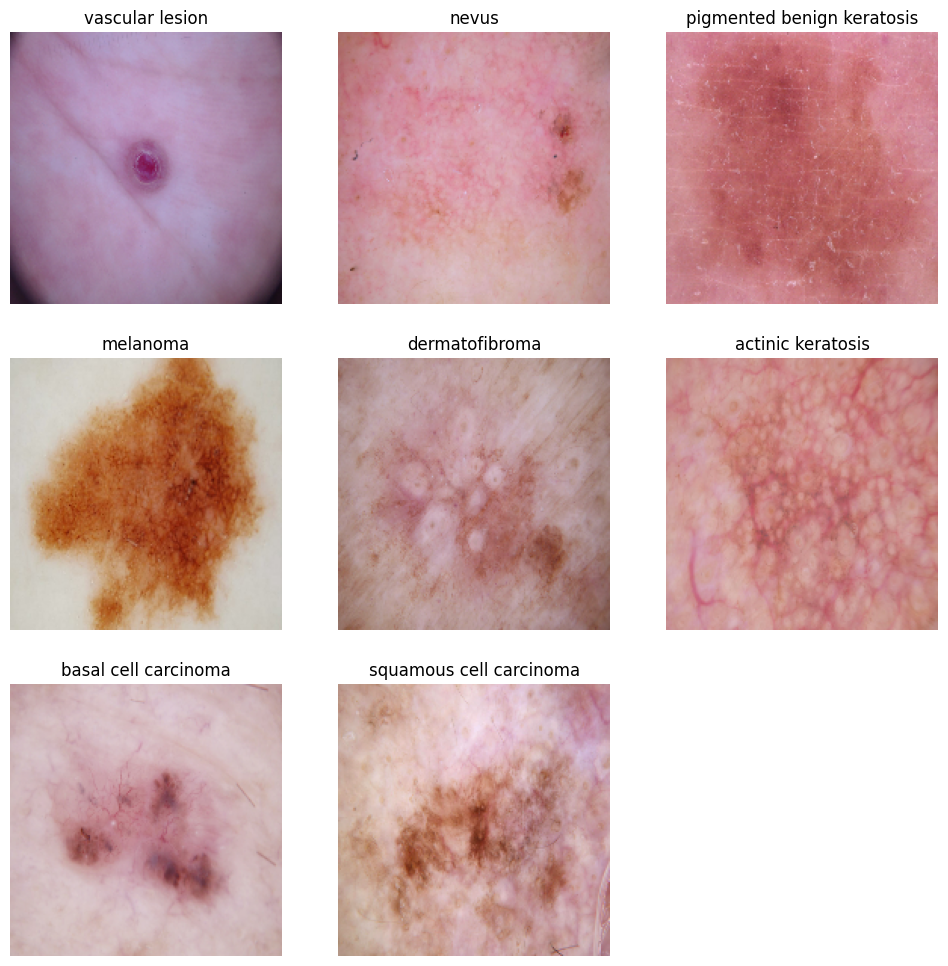

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Dictionary to store the first image of each class
class_images = {}
for img, label in zip(image_batch, label_batch):
    class_name = class_names[label.numpy()]
    if class_name not in class_images:
        class_images[class_name] = img  # Store the first image of the class
    if len(class_images) == len(class_names):  # Stop once we have one of each
        break

# Plot one image per class
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 classes
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define input shape
input_shape = (img_height, img_width, 3)  # Image dimensions with 3 color channels

# Build CNN Model
model = keras.Sequential([
    # Normalize pixel values
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # First convolutional block
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Flatten layer to convert 2D feature maps to 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(64, activation='relu'),

    # Output layer with softmax activation for 9 classes
    layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer-labeled classes
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,032,073 (30.64 MB)

 Trainable params: 8,032,073 (30.64 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 169ms/step - accuracy: 0.1795 - loss: 2.1709 - val_accuracy: 0.2119 - val_loss: 2.4892
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2636 - loss: 2.0034 - val_accuracy: 0.2288 - val_loss: 2.0611
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3589 - loss: 1.7925 - val_accuracy: 0.2881 - val_loss: 2.0463
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4310 - loss: 1.6159 - val_accuracy: 0.3220 - val_loss: 2.1427
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4678 - loss: 1.5415 - val_accuracy: 0.3051 - val_loss: 2.3115
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4936 - loss: 1.4673 - val_accuracy: 0.3559 - val_loss: 2.0089
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4788 - loss: 1.4687 - val_accuracy: 0.2881 - val_loss: 2.5358
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5242 - loss: 1.3954 - val_accuracy: 0.3644 

### Visualizing training results

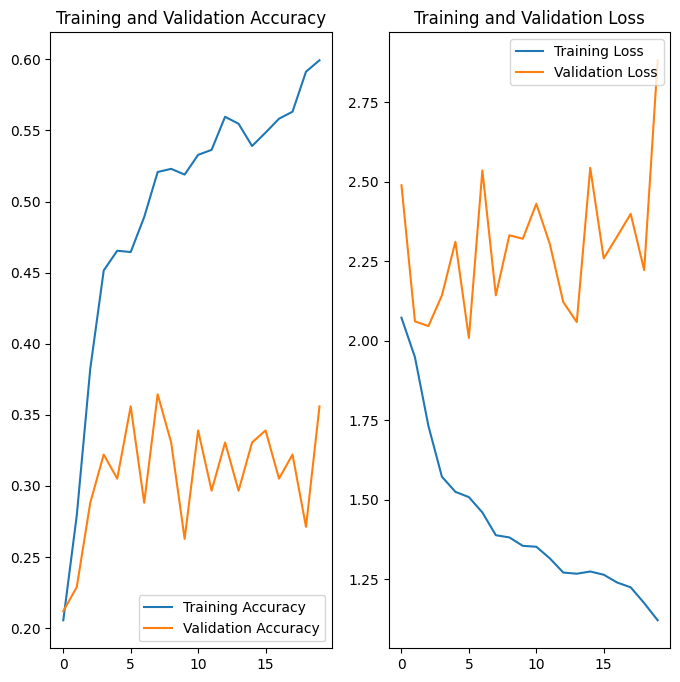

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observations:**



1.   **Training Accuracy consistently higher than Validation Accuracy:**  The training accuracy is noticeably and consistently higher than the validation accuracy throughout the training process. This is a potential indicator of overfitting.

2.   **Validation Accuracy plateaus and fluctuates:** The validation accuracy seems to plateau or stagnate after a few epochs, showing limited improvement despite continued training. It also exhibits fluctuations, suggesting the model might be struggling to generalize well to unseen data.

3. **Training Loss continues to decrease, Validation Loss plateaus/increases** : The training loss steadily decreases, which is expected. However, the validation loss, after an initial decrease, plateaus and even shows some increase towards the later epochs. This is a strong indication of overfitting, where the model is improving its performance on the training data at the expense of generalization to the validation data.

4. **Gap between Training and Validation Loss:** There's a noticeable and widening gap between the training and validation loss as training progresses, further supporting the suspicion of overfitting.

**Interpretation and Findings:**

**Evidence of Overfitting:** The trends observed strongly suggest that the model is overfitting the training data.  The model is likely learning noise or specific features of the training set that are not representative of the underlying data distribution, leading to poor performance on unseen data (the validation set).

**Lack of Underfitting Evidence:** There are no clear signs of underfitting.  The training accuracy is reasonably high, and the training loss is decreasing, suggesting the model is learning something meaningful from the data.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_data_augmentation(train_data):
    # Apply data augmentation techniques
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Convert the PrefetchDataset to a NumPy array
    # Assuming train_data is your PrefetchDataset
    images, labels = next(iter(train_data.take(1)))  # Get one batch
    images = images.numpy()  # Convert to NumPy array

    # Now you can apply augmentation
    augmented_data = datagen.flow(images, labels, batch_size=images.shape[0]) # Pass labels as well for flow

    return augmented_data

# Apply data augmentation to training data if overfitting is detected
augmented_train_data = apply_data_augmentation(train_ds)


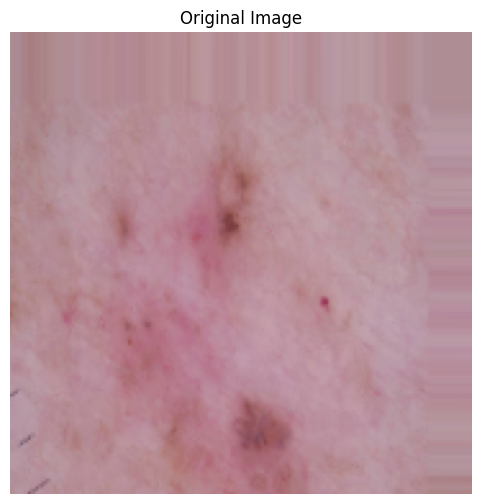

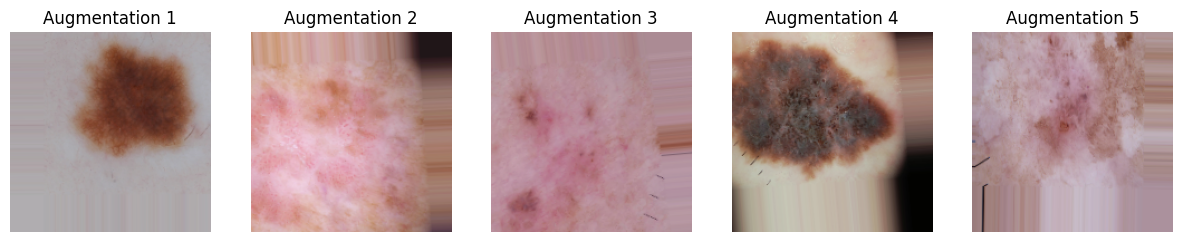

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import numpy as np

# Get a batch of images and labels from the augmented data
augmented_images, augmented_labels = next(iter(augmented_train_data))

# Select the first image for visualization
image_to_visualize = augmented_images[0]

# Display the original image (before augmentation)
plt.figure(figsize=(6, 6))
plt.imshow(image_to_visualize.astype("uint8"))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Apply augmentation and display a few augmented versions
num_augmentations_to_display = 5  # Number of augmented images to show

plt.figure(figsize=(15, 5))
for i in range(num_augmentations_to_display):
    # Use __next__() instead of next()
    augmented_image = augmented_train_data.__next__()[0][0]  # Get the next augmented image
    plt.subplot(1, num_augmentations_to_display, i + 1)
    plt.imshow(augmented_image.astype("uint8"))
    plt.title(f"Augmentation {i + 1}")
    plt.axis("off")

plt.show()

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Define input shape
input_shape = (img_height, img_width, 3)  # Image dimensions with 3 color channels

# Build CNN Model with Dropout
model = keras.Sequential([
    # Normalize pixel values
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # First convolutional block
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Flatten layer to convert 2D feature maps to 1D
    layers.Flatten(),

    # Fully connected layers with Dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(64, activation='relu'),

    # Output layer with softmax activation for 9 classes
    layers.Dense(len(class_names), activation='softmax')
])






### Compiling the model

In [20]:
## Your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
# Train the model
epochs = 20
history = model.fit(
  augmented_train_data, # Use augmented training data
  validation_data=val_ds,
  epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0625 - loss: 2.2137 - val_accuracy: 0.1356 - val_loss: 2.2650
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.0625 - loss: 2.2505 - val_accuracy: 0.1780 - val_loss: 2.1233
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.0312 - loss: 2.1003 - val_accuracy: 0.2203 - val_loss: 2.1311
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2188 - loss: 2.0993 - val_accuracy: 0.1441 - val_loss: 2.1222
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.1875 - loss: 2.0190 - val_accuracy: 0.1356 - val_loss: 2.1277
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.3125 - loss: 1.9218 - val_accuracy: 0.1356 - val_loss: 2.1849
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.2188 - loss: 2.0757 - val_accuracy: 0.1356 - val_loss: 2.1863
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.0938 - loss: 1.9019 - val_accuracy: 0.1356 - val_loss: 2.

### Visualizing the results

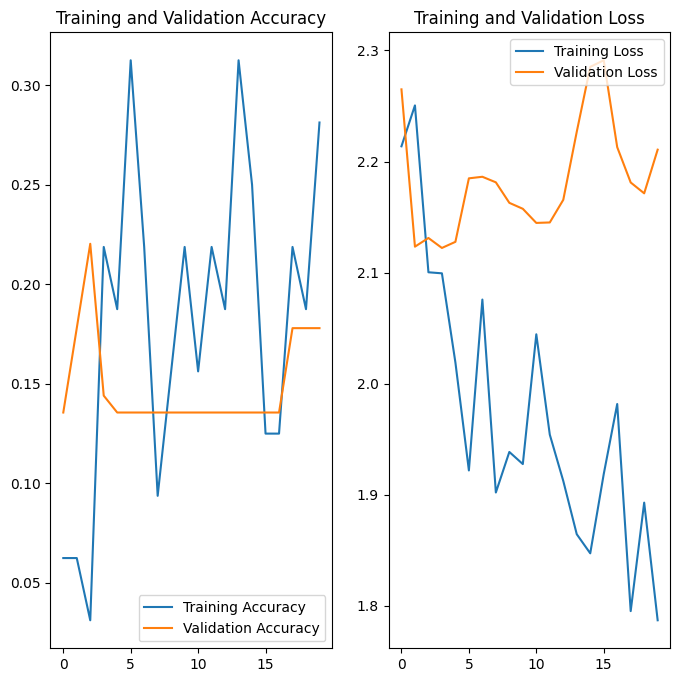

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations:**

**Training Accuracy fluctuates wildly:** The training accuracy shows significant fluctuations and spikes throughout the training process. This is unusual and could indicate instability in the training.

**Validation Accuracy is very low and stagnant:** The validation accuracy is extremely low (around 0.14) and shows almost no improvement throughout training. It's practically flat.

**Training Loss fluctuates and doesn't decrease consistently:** Similar to the training accuracy, the training loss exhibits large fluctuations and doesn't show a clear, consistent downward trend.

**Validation Loss is high and relatively stagnant:** The validation loss is high (above 2.0) and, like the validation accuracy, shows minimal improvement.

**Interpretation and Findings:**

Clear Evidence of Underfitting: The extremely low and stagnant validation accuracy, along with the high and relatively unchanging validation loss, strongly suggest that the model is underfitting the data. This means the model is not learning the underlying patterns in the data and is failing to generalize.

**Possible Reasons for Underfitting:**

**Model Complexity:** The model might be too simple to capture the complexity of the data. It could lack the capacity to learn the necessary features.
**Insufficient Training:** Although it's hard to tell definitively without knowing the training duration, it's possible that the model hasn't been trained for long enough to converge (though the lack of any improvement suggests otherwise).
**Problem with the Data:** There might be issues with the data itself, such as incorrect labels, insufficient data, or highly noisy data, which could hinder the learning process.
**Bug in the Code:** It's also possible that there is a bug in the code related to the model training, data loading, or evaluation process.
Inappropriate Hyperparameters: The model's hyperparameters might be poorly chosen, preventing effective learning.


Comparison with the Previous Run:
**bold text**
The previous model run showed signs of overfitting, where the training accuracy was significantly higher than the validation accuracy, and the validation loss plateaued or increased.

Is there Improvement? No, the model has gotten significantly worse.  This run shows severe underfitting, a much worse outcome than the previous overfitting. The model is essentially not learning anything meaningful.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.

from glob import glob  # Import glob

# Assuming 'data_dir_train' is the path to your training dataset directory
# Get a list of all image paths
path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]

# Extract class labels from the paths (assuming your directory structure is class_name/image.jpg)
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]

# Create a pandas DataFrame to store the data
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns=['Path', 'Label'])

# Get the class distribution
class_distribution = original_df['Label'].value_counts()

print(class_distribution)

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**Seborrheic keratosis** has the least number of samples with only 77 images.
#### - Which classes dominate the data in terms proportionate number of samples?
The following classes dominate the data:

1. Pigmented benign keratosis: With 462 samples, it has the highest number of images.
2. Melanoma: With 438 samples, it is the second most dominant class.
3. Basal cell carcinoma: With 376 samples, it has a substantial number of images.
4. Nevus: With 357 samples, it is also a significant portion of the dataset.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5DC0504450>: 100%|██████████| 500/500 [00:20<00:00, 24.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DC01BBB90>: 100%|██████████| 500/500 [00:17<00:00, 28.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DCF4F1F90>: 100%|██████████| 500/500 [00:13<00:00, 36.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5DD496AF10>: 100%|██████████| 500/500 [01:16<00:00,  6.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F5DC04ED3D0>: 100%|██████████| 500/500 [01:04<00:00,  7.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5DA99B7FD0>: 100%|██████████| 500/500 [00:13<00:00, 36.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5DC0522310>: 100%|██████████| 500/500 [00:30<00:00, 16.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DC03BE290>: 100%|██████████| 500/500 [00:13<00:00, 36.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DC055D250>: 100%|██████████| 500/500 [00:13<00:00, 36.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025387.jpg_285daf4b-33e5-462e-96a7-300389b9422c.jpg',
 '/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024581.jpg_80696563-3021-4e32-8abd-a0a8856756c4.jpg',
 '/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026174.jpg_abb337f3-6608-4413-baf7-0618ac0ff1a3.jpg',
 '/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026069.jpg_e50f5b13-bcc6-488d-a893-08f081293da2.jpg',
 '/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented b

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [31]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train="/content/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", # Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", # Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here

# Define input shape
input_shape = (img_height, img_width, 3)  # Image dimensions with 3 color channels

# Build CNN Model with Normalization
model = keras.Sequential([
    # Rescaling layer for normalization
    layers.Rescaling(1./255, input_shape=input_shape),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.1721 - loss: 2.1562 - val_accuracy: 0.2777 - val_loss: 1.8686
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.3220 - loss: 1.7418 - val_accuracy: 0.4410 - val_loss: 1.4941
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.3975 - loss: 1.5705 - val_accuracy: 0.4358 - val_loss: 1.4750
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step - accuracy: 0.4178 - loss: 1.4737 - val_accuracy: 0.5308 - val_loss: 1.3485
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.4534 - loss: 1.4126 - val_accuracy: 0.4699 - val_loss: 1.3871
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.4817 - loss: 1.3711 - val_accuracy: 0.5160 - val_loss: 1.3314
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.5096 - loss: 1.2760 - val_accuracy: 0.5754 - val_loss: 1.2137
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - accuracy: 0.5414 - loss: 1

#### **Todo:**  Visualize the model results

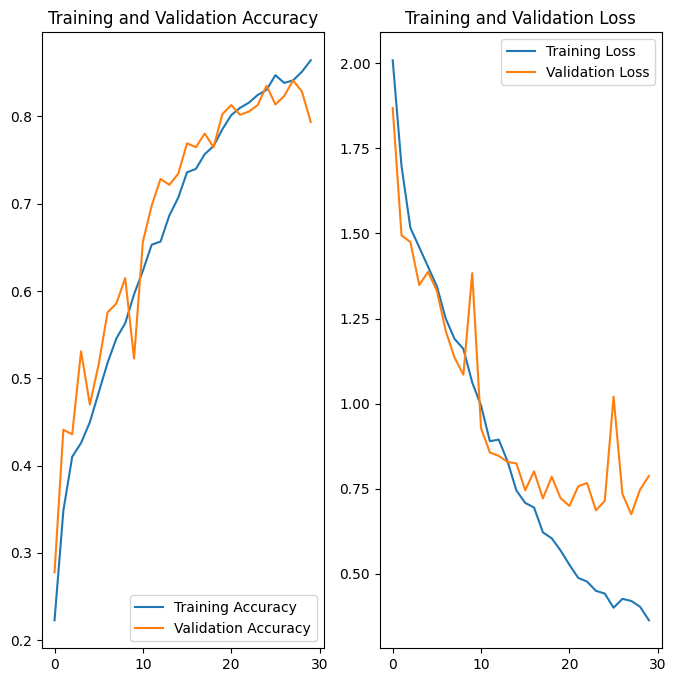

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observations:**

1. **Training and Validation Accuracy closely aligned:** The training and validation accuracy curves track each other relatively closely throughout the training process. This is a positive sign, suggesting that the model is generalizing well to unseen data.

2. **Validation Accuracy shows good improvement:** The validation accuracy reaches a reasonable level (around 0.8) and shows consistent improvement over the epochs, indicating that the model is learning effectively.

3. **Training and Validation Loss decrease together:** Both training and validation loss curves show a consistent downward trend, further supporting the idea that the model is learning and generalizing.

4. **Smaller gap between Training and Validation Loss:** The gap between the training and validation loss is relatively small and stable, indicating that the model is not overfitting significantly.

**Assessment of Overfitting/Underfitting:**

1. **Reduced Overfitting:** Compared to the initial model run (where we saw significant overfitting), this model shows a substantial reduction in overfitting. The close alignment of training and validation metrics indicates that the model is no longer memorizing the training data at the expense of generalization.

2. **No Significant Underfitting:** The model achieves a reasonable validation accuracy, and the loss curves show a clear decreasing trend. This suggests that the model is not significantly underfitting the data. It has sufficient capacity to learn the underlying patterns.


